# Project 1 : Monte Carlo Simulation of the One-Dimensional Ising Model

## Context and Motivation
- The Ising model is one of the pillars of statistical mechanics, providing a fundamental framework for studying phase transitions and magnetic systems.
- While the one-dimensional (1D) version of this model does not exhibit a phase transition at non-zero temperatures, it serves as an essential pedagogical tool and a benchmark for numerical methods.
- This project focuses on simulating a chain of $N$ spins interacting via the exchange energy $J$ in the absence of an external magnetic field.

## Theoretical Background
- In the 1D Ising model, the energy of a configuration is determined by the interaction between nearest neighbors.
- One of the key objectives of this study is to compare numerical results obtained via the Metropolis algorithm with exact analytical solutions. Specifically, we will verify the internal energy $E(T)$ against the theoretical formula:
 $$E(T) = -N \tanh \beta J \quad \text{with} \quad \beta = \frac{1}{k_B T} $$

## Objectives of the Project
The primary goal of this work is to implement a Monte Carlo simulation using the heat bath equilibrium method to explore the thermodynamic properties of the system. The project is structured around the following key tasks:
- **Algorithm Implementation:** Developing a robust simulation using periodic boundary conditions and the Metropolis algorithm.
- **Thermalization Analysis:** Estimating the time required for the system to reach equilibrium starting from different initial configurations (all spins up or random).
- **Thermodynamic Observables:** Computing energy $\langle E \rangle$, magnetisation $\langle M \rangle$, specific heat $C$, and magnetic susceptibility $\chi$ as functions of time $t$ and temperature $T$.
- **Experimental Validation:** Applying the model to a real-world material, FeTAC, by utilizing its specific exchange interaction $J/k = 17.4K$.


---

## Python 

### import

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from utils import *

### Constants

In [ ]:
# Constante Physique
global N, spins, KB, N_thermalisation, J, h

N = 100 # Nombre de spins dans la chaine
spins = np.random.choice([-1, 1], size=N) # Notre système aléatoire

KB = 1. # Constante de Boltzmann
J = 1. # Constante d'intéraction avec le proche voisin
h = 0. # Constante Magnétisme = 0 cause of an absence of an external magnetic field

Ti = 10. # Température initial du système
Tf = 0.1 # Température final du système

# Constant numérique
dT = 0.1 # pas entre chaque temperature que notre systeme va atteindre
T = np.arange(Ti, Tf+np.sign(Tf-Ti)*dT, np.sign(Tf-Ti)*dT) # np.arange(Ti, Tf + dT, dT) # liste de température par les quel le systeme va passser

Nt = 1000 # Nombre de pas de temps a chaque étape
N_thermalisation = 100 * Nt # Nombre de pas de temps pour thérmaliser notre système 

---

### Monte Carlo method


#### Metropolis step for the Ising model

1. **Selection:** Pick a random spin site $i$ from the lattice of size $N$.
2. **Trial:** Propose a spin flip: $s_i \rightarrow -s_i$.
3. **Energy Calculation:** Compute the energy change $\Delta E$ associated with this flip.
4. **Acceptance Criterion:**
   - If $\Delta E \leq 0$: The change is **accepted**.
   - If $\Delta E > 0$: The change is accepted only with a probability $P = e^{-\beta \Delta E}$.
   - Otherwise, the spin remains unchanged.

#### Energy change :

- $\Delta E = 2J s_i (s_{i-1} + s{i+1})$ 

#### Thermalization

Before starting to measure physical observables, the system must undergo a **thermalization** phase. 

The initial state is usually arbitrary and does not belong to the Boltzmann distribution. Measurements taken too early would be biased by this starting point.
So we wait for the system's total energy to fluctuate around a stable mean value. Once this "steady state" is reached, we can assume the samples are valid representatives of the canonical ensemble. Because measurements are only averaged **after** thermalization to ensure that the computed means $\langle E \rangle$ or $\langle M \rangle$ reflect the true physics of the model rather than the simulation's transient behavior.

In [ ]:
def compute_P(E : float, T : float) -> float:
  return np.exp(-E/(T*KB))

def compute_dE(i : int) -> float:
  return 2*J*spins[i]*(spins[(i-1)%N] + spins[(i+1)%N]) # modulo % for PBC

def evolution(T : float) -> None :
  i = np.random.randint(N)
  dE = compute_dE(i)
  if dE <= 0 or compute_P(dE,T) > np.random.rand() :
    spins[i] *= -1
  return 

def thermalisation(T : float) -> None :
  for _ in range(N_thermalisation) :
    evolution(T)
  return 

---

### Computation functions

To monitor the system's evolution in Monte Carlo's method, we track the average of this quantities :

#### Hamiltonian of the Ising model in 1D :

- $H = - J \Sigma_{i=1}^{N} s_is_{i+1} + h \Sigma_{i=1}^{N} s_i \quad s_i = \pm 1 \quad \text{with PBC :} \quad s_{N+1} = s_{1} $

#### Magnetisation :

- $ M = \frac{\Sigma_{i=1}^{N} s_i}{N} $

#### Suceptibility :

- $\chi = \beta(\langle m^2\rangle-\langle m\rangle^2)$

#### Specific Heat :

- $ C_v = \frac{\beta^2}{N}(\langle E^2\rangle-\langle E\rangle^2) $



In [28]:
def compute_E() -> float:
  return -J*( np.sum(spins[:-1]*spins[1:]) + spins[0]*spins[-1] ) - h*np.sum(spins) # le terme spins[0]*spins[-1] pour la PBC

def compute_m() -> float:
  return np.mean(spins)

def compute_suceptibility(m : np.array, T : float) -> float:
  return np.var(m) / (T*KB)

def compute_specific_heat(E : np.array, T : float) -> float:
  return np.var(E)/(N*T*T*KB*KB)

### Theoric quantities

We need to compare our result with the theorical result for interpretation.

#### Theoric Energy :

- $E(T) = -N \tanh \beta J \quad $ for ($h=0$).

#### Theoric Magnetisation :

- $m(T, h) = \frac{\sinh(\beta h)}{\sqrt{\sinh^2(\beta h) + e^{-4\beta J}}}$

#### Theoric Suceptibility :

- $\chi(T, h) = \beta \frac{e^{-4\beta J} \cosh(\beta h)}{\left[ \sinh^2(\beta h) + e^{-4\beta J} \right]^{3/2}}$

#### Theoric Specific Heat :

- $c_v(T) = k_B \left( \frac{J}{k_B T} \right)^2 \frac{1}{\cosh^2\left( \frac{J}{k_B T} \right)} \quad $ for ($h=0$).

In [29]:
def E_theoric(T : np.array) -> np.array: 
    beta = 1.0 / (KB * T)
    return -N * np.tanh(beta * J)

def m_theoric(T : np.array) -> np.array: 
    beta = 1.0 / (KB * T)
    num = np.sinh(beta * h)
    denom = np.sqrt(np.sinh(beta * h)**2 + np.exp(-4 * beta * J))
    return num / denom

def compute_suceptibility_theoric(T : np.array) -> np.array:
    beta = 1.0 / (KB * T)
    num = beta * np.exp(-4 * beta * J) * np.cosh(beta * h)
    denom = (np.sinh(beta * h)**2 + np.exp(-4 * beta * J))**(1.5)
    return num / denom

def compute_specific_heat_theoric(T : np.array) -> np.array: 
    beta = 1.0 / (KB * T)
    return KB * (beta * J)**2 * (1.0 / np.cosh(beta * J)**2)

---

### Simulation

In [ ]:
# Init
E_list, m_list, suceptibility_list, specific_heat_list = [], [], [], [] # liste of measurement
 
# Evolution of the temp
for Tj in T :
  thermalisation(Tj)
  print(f"Thermalisation {Tj.round(2)}/{Tf} complete")
  m_temp, E_temp = [], [] # reinitialisation des listes temporaires
  for _ in range(Nt) :
    evolution(Tj) # change un s_i -> - s_i

    # Calcul des magnétisations et énergies
    m_temp.append(compute_m())
    E_temp.append(compute_E())
  
  # Stock les valeur
  E_list.append(np.mean(E_temp))
  m_list.append(np.mean(np.abs(m_temp))) # en valeur absolue car le système est invariant
  suceptibility_list.append(compute_suceptibility(np.array(m_temp), Tj))
  specific_heat_list.append(compute_specific_heat(np.array(E_temp), Tj))

# theorical mesure pour comparer nos resultats
E_theoric_list = E_theoric(T)
m_theoric_list = m_theoric(T)
suceptibility_theoric = compute_suceptibility_theoric(T)
specific_heat_theoric = compute_specific_heat_theoric(T)

Thermalisation 10.0/0.1 complete
Thermalisation 9.9/0.1 complete
Thermalisation 9.8/0.1 complete
Thermalisation 9.7/0.1 complete
Thermalisation 9.6/0.1 complete
Thermalisation 9.5/0.1 complete
Thermalisation 9.4/0.1 complete
Thermalisation 9.3/0.1 complete
Thermalisation 9.2/0.1 complete
Thermalisation 9.1/0.1 complete
Thermalisation 9.0/0.1 complete
Thermalisation 8.9/0.1 complete
Thermalisation 8.8/0.1 complete
Thermalisation 8.7/0.1 complete
Thermalisation 8.6/0.1 complete
Thermalisation 8.5/0.1 complete
Thermalisation 8.4/0.1 complete
Thermalisation 8.3/0.1 complete
Thermalisation 8.2/0.1 complete
Thermalisation 8.1/0.1 complete
Thermalisation 8.0/0.1 complete
Thermalisation 7.9/0.1 complete
Thermalisation 7.8/0.1 complete
Thermalisation 7.7/0.1 complete
Thermalisation 7.6/0.1 complete
Thermalisation 7.5/0.1 complete
Thermalisation 7.4/0.1 complete
Thermalisation 7.3/0.1 complete
Thermalisation 7.2/0.1 complete
Thermalisation 7.1/0.1 complete
Thermalisation 7.0/0.1 complete
Thermal

---

### Plot depending on the Temperature

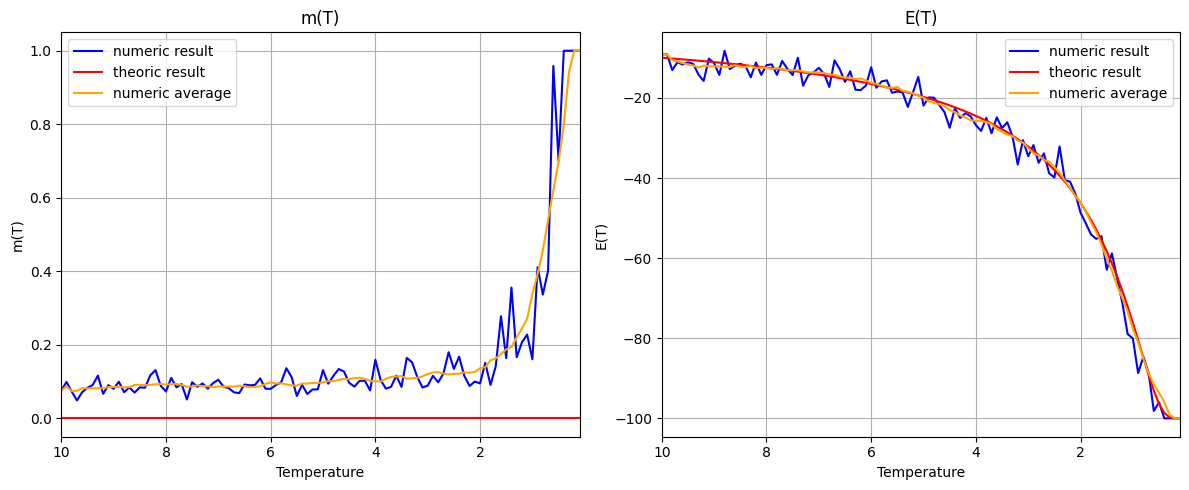

Energy error : 1.901698329401388
magnetisation error : 0.16625480000000004


In [ ]:
plot2(T, m_list, E_list, y1_theoric=m_theoric_list, y2_theoric=E_theoric_list, show_y1_average=True, show_y2_average=True, title1="m(T)", title2="E(T)", x_label='Temperature')

E_error = error(E_list, E_theoric_list)
m_error = error(m_list, m_theoric_list)

print("Energy error :", E_error)
print("magnetisation error :", m_error)

#### Observation 1

The theoretical magnetisation and energy are **almost identical** than the average magnetisation and energy obtained with our simulation.

We find : $\quad \langle m\rangle << 1 \quad $ and $\quad \langle E\rangle \approx -N \tanh \beta J$.

Magnetization seems like going to 1 as the temperature come closer to 0.

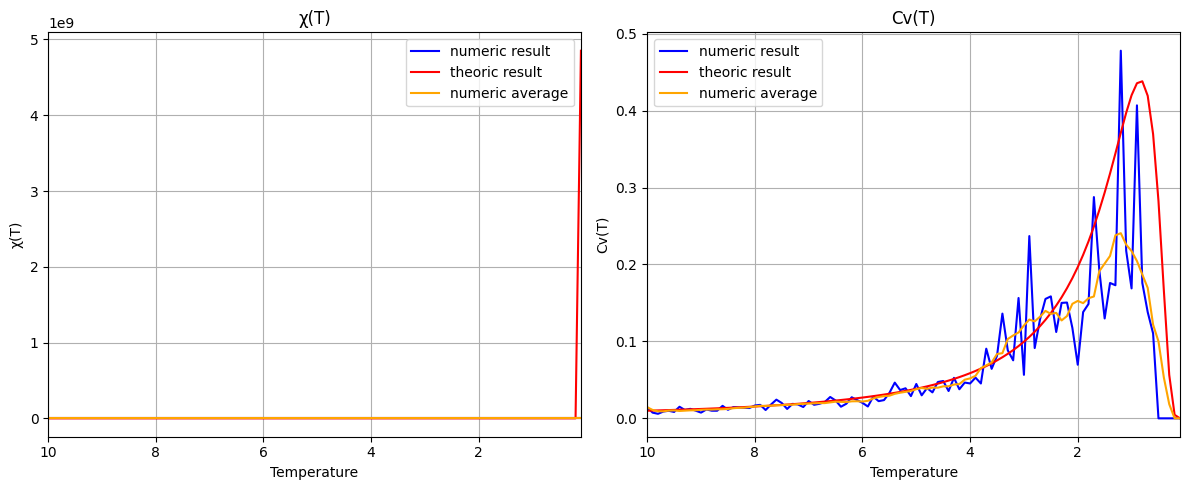

Suceptibility error : 48517653.44301894
Specific heat error : 0.03589354923127812


In [56]:
plot2(T, suceptibility_list, specific_heat_list, y1_theoric=suceptibility_theoric, y2_theoric=specific_heat_theoric, show_y1_average=True, show_y2_average=True, title1="χ(T)", title2="Cv(T)", x_label='Temperature')

X_error = error(suceptibility_list, suceptibility_theoric)
C_error = error(specific_heat_list, specific_heat_theoric)

print("Suceptibility error :", X_error)
print("Specific heat error :", C_error)

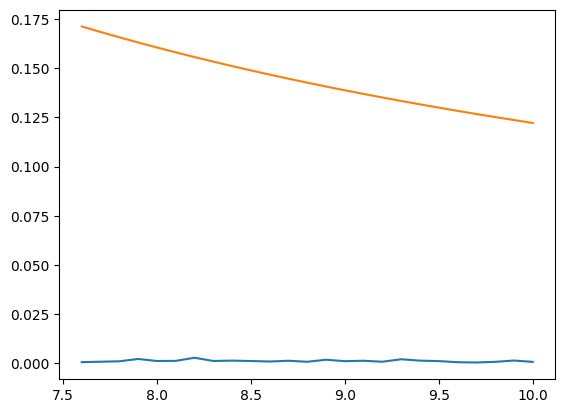

Suceptibility error : 0.1429028920123988


In [60]:
T_begin = T[:len(T)//4]
X_begin = suceptibility_list[:len(T)//4]
XT_begin = suceptibility_theoric[:len(T)//4]

plt.plot(T_begin, X_begin)
plt.plot(T_begin, XT_begin)
plt.show()

X_error = error(X_begin, XT_begin)
print("Suceptibility error :", X_error)


#### Observation 2

the susceptibility is far from its theoretical value, but the theoretical specific heat is **almost identical** than the average numeric value.

With the second plot for susceptibility, we can see that if we take high temperatures, we see that our simulation makes few errors, it's for values close to 0 that we have a problem.

Let's try to redo our simulation with $ \langle m \rangle = 0$ to see if the susceptibility can be closer to the theoretical results.
Because we calculate susceptibility with magnetization that is not quite 0 as it should be.

In [ ]:
# redefine how susceptibility is calculated
def compute_suceptibility_2(m : np.array, T : float) -> float:
  return np.mean(m**2) / (T*KB) # we take <m> = 0

# New simulation (no need to look at all the quantities E, Cv)
m_list, suceptibility_list = [], [] # liste of measurement

# Evolution of the temp
for Tj in T :
  thermalisation(Tj)
  print(f"Thermalisation {Tj.round(2)}/{Tf} complete")
  m_temp = [] # reinitialisation de la liste temporaire
  for _ in range(Nt) :
    evolution(Tj) # change un s_i -> - s_i

    # Calcul des magnétisations
    m_temp.append(compute_m())
  
  # Stock les valeur
  m_list.append(np.mean(np.abs(m_temp))) # en valeur absolue car le système est invariant
  suceptibility_list.append(compute_suceptibility_2(np.array(m_temp), Tj))

Thermalisation 10.0/0.1 complete
Thermalisation 9.9/0.1 complete
Thermalisation 9.8/0.1 complete
Thermalisation 9.7/0.1 complete
Thermalisation 9.6/0.1 complete
Thermalisation 9.5/0.1 complete
Thermalisation 9.4/0.1 complete
Thermalisation 9.3/0.1 complete
Thermalisation 9.2/0.1 complete
Thermalisation 9.1/0.1 complete
Thermalisation 9.0/0.1 complete
Thermalisation 8.9/0.1 complete
Thermalisation 8.8/0.1 complete
Thermalisation 8.7/0.1 complete
Thermalisation 8.6/0.1 complete
Thermalisation 8.5/0.1 complete
Thermalisation 8.4/0.1 complete
Thermalisation 8.3/0.1 complete
Thermalisation 8.2/0.1 complete
Thermalisation 8.1/0.1 complete
Thermalisation 8.0/0.1 complete
Thermalisation 7.9/0.1 complete
Thermalisation 7.8/0.1 complete
Thermalisation 7.7/0.1 complete
Thermalisation 7.6/0.1 complete
Thermalisation 7.5/0.1 complete
Thermalisation 7.4/0.1 complete
Thermalisation 7.3/0.1 complete
Thermalisation 7.2/0.1 complete
Thermalisation 7.1/0.1 complete
Thermalisation 7.0/0.1 complete
Thermal

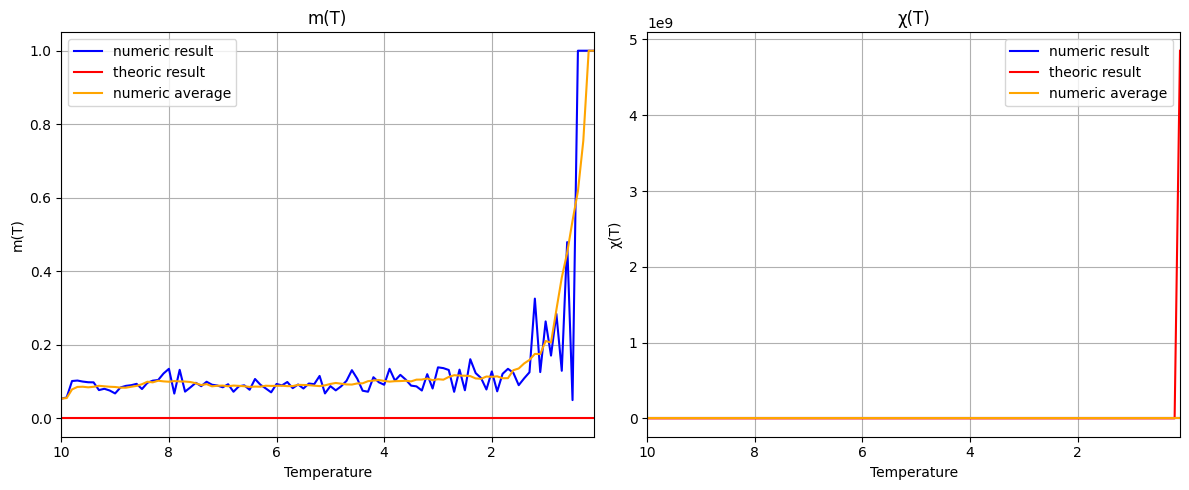

magnetisation error : 0.14338540000000002
Suceptibility error : 48517653.22695389


In [63]:
plot2(T, m_list, suceptibility_list, y1_theoric=m_theoric_list, y2_theoric=suceptibility_theoric, show_y1_average=True, show_y2_average=True, title1="m(T)", title2="χ(T)", x_label='Temperature')

m_error = error(m_list, m_theoric_list)
X_error = error(suceptibility_list, suceptibility_theoric)

print("magnetisation error :", m_error)
print("Suceptibility error :", X_error)

#### Observation 3

Still a problem with suceptibility...

--- 

### Conclusion